# Preface

In this notebook, we apply RNN and its variants to predict the positivity of movie reviews. This notebook serves the following purposes:
  * Introduce basic usage of RNN/LSTM
  * Introduce basic text data handling

In [6]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
sns.set(font_scale=1.5, style='darkgrid')

In [7]:
tf.config.set_visible_devices([], 'GPU') # Disable GPU (runtime slow)

# The IMDB Dataset

We will use the [IMDB dataset](http://ai.stanford.edu/~amaas/data/sentiment/) consisting of movie reviews of various movie titles. 

Our goal is to develop a machine learning model which can predict, given a text review, whether the sentiment of the review is postive (1) or negative (0). 

THe IMDB dataset is built into `keras.datasets`.

In [8]:
from tensorflow.keras.datasets import imdb

In [9]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=20000)

We can see that the inputs are already coded into integers

In [10]:
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


These are actually word encodings based on frequency. For details, have a look a the documentation of the dataset, e.g. [here](http://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=2ahUKEwjE69P55NXnAhXLfH0KHSFoClAQygQwAHoECAQQBw&url=http%3A%2F%2Fkeras.io%2Fdatasets%2F%23imdb-movie-reviews-sentiment-classification&usg=AOvVaw3ZEeYraF9cI7oBodf2K9ea).

To see what the review text actually is, we write a simple function that converts the encodings back into words. This is done using the `imdb.get_word_index()` method.

In [11]:
def to_words(word_ids):
    """
    Convert list of word_ids back to words.
    Special chars for 0-3 are based on the default kwargs of
    imdb.load_data()
    """
    index_from = 3
    word_to_id = imdb.get_word_index()
    word_to_id = {k: (v + index_from) for k, v in word_to_id.items()}
    word_to_id['<PAD>'] = 0
    word_to_id['<START>'] = 1
    word_to_id['<UNK>'] = 2
    word_to_id['<UNUSED>'] = 3
    id_to_word = {value: key for key, value in word_to_id.items()}
    return ' '.join(id_to_word[id] for id in word_ids)

Let us look at some randomly chosen reviews:

In [12]:
idx = np.random.choice(len(x_train))
print('Sentiment: ', y_train[idx])
print('Review: ', to_words(x_train[idx]))

Sentiment:  0
Review:  <START> let me start out by saying i will try not to put too many spoilers in this normally i enjoy robin williams movies however this gem was not one of them it was billed as a suspenseful thriller the night listener was anything but to be blunt there were 6 people in the theater opening day 2 walked out for good reason the movie was in my opinion poorly written and directed the acting was alright but again there wasn't anything to work with the movie is about a storyteller who reads a good book by a dying kid however insert spooky here no one can verify the kids existence so williams goes to wisconsin to try and find the author however all he gets is a headache and excuses from the boys caretaker there thats it thats all you wait for about an hour and a half and movie ends it had as many thrills and chills as a dentist office visit the homosexual undertones or overtones had really nothing to do with the story and the movie had a little profanity but it seemed t

## Preprocessing the data for training

Let us check what is the length (number of words) for each review.

In [13]:
lengths_train = list(map(len, x_train))

Text(0.5, 0, 'Number of Words')

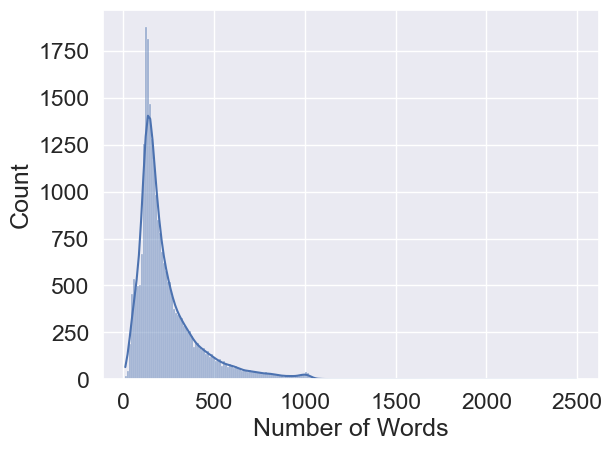

In [14]:
ax = sns.histplot(lengths_train, kde=True)
ax.set_xlabel('Number of Words')

The number of words clearly varies from review to review, so we pad them. This is performed by the `sequence.pad_sequences` function. Any review longer than `maxlen` is cut off, and those shorter are padded (in the front) by 0s. 

In [15]:
from tensorflow.keras.preprocessing import sequence

In [16]:
x_train = sequence.pad_sequences(x_train, maxlen=100)
x_test = sequence.pad_sequences(x_test, maxlen=100)

# Build a Simple RNN Model

Now, we are ready to build a RNN model to learn to predict the sentiment given the review text.

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback

In [18]:
model = Sequential()

Here, we cannot directly work with x_train because they are encoded integers. Instead, we first use an `Embedding` layer that casts these integer encodings to a feature space. 

For example, `Embedding(5, 2)` is a 5x2 matrix that maps integer encodings (0,...,4) into 5 real-valued vectors of 2 dimensions:

| Coding | Embedded Vectors
| --- | --- |
| 0 | [0.5, 1.0] |
| 1 | [1.0, 1.2] |
| 2 | [0.1, -0.6] |
| 3 | [0.3, 0.5] |
| 4 | [-0.4, -0.1] |

This embedding is trainable, so we can learn to embed these encodings in the right way relevant to the task: words of similar meaning should have similar embeddings!

In [19]:
model.add(Embedding(20000, 128))

Now, we can add the RNN layers, and append to it an output `Dense` layer.

In [20]:
model.add(SimpleRNN(128))
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,593,025
Trainable params: 2,593,025
Non-trainable params: 0
_________________________________________________________________


Since we are going to test several models, we will write some functions to train, save and evaluate models. These functions are self-explanatory.

In [22]:
def train_and_save(model, path, force=False, optimizer=Adam(0.001)):
    """
    Looks for saved model in path, if found, load.
    If not, compile, train and save model to path
    If force=True, will always retrain
    """
    model_save_dir = pathlib.Path(path)
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'],
    )
    
    if model_save_dir.exists() and not force:
        model.load_weights(str(model_save_dir))
    else:
        history = model.fit(
            x_train,
            y_train,
            batch_size=32,
            epochs=15,
            validation_data=(x_test, y_test),
            callbacks=[TqdmCallback(verbose=1)],
            verbose=0,
        )
        model.save_weights(str(model_save_dir))
        results = pd.DataFrame(history.history)
        results['epoch'] = history.epoch
        return results

In [23]:
def evaluate(model, train_data, test_data):
    """
    Evaluate model on train/test sets
    """
    eval_train = model.evaluate(*train_data, batch_size=2048, verbose=0)
    eval_test = model.evaluate(*test_data, batch_size=2048, verbose=0)
    print(f'Train - loss = {eval_train[0]:.3f}, acc = {eval_train[1]:.3f} ')
    print(f'Test - loss = {eval_test[0]:.3f}, acc = {eval_test[1]:.3f} ')

In [24]:
train_and_save(model=model, path='imdb_simple_rnn.h5')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-02-11 10:19:07.334014: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


,loss,accuracy,val_loss,val_accuracy,epoch
0,0.661999,0.58072,0.663759,0.57756,0
1,0.563280,0.70560,0.561090,0.71536,1
2,0.458962,0.78404,0.600870,0.69372,2
3,0.413078,0.81280,0.635448,0.69920,3
4,0.352167,0.84920,0.677884,0.69632,4
5,0.373250,0.83040,0.711714,0.63276,5
6,0.299405,0.87644,0.651237,0.74668,6
7,0.259483,0.89576,0.753486,0.70452,7
8,0.249061,0.89976,0.770451,0.71580,8
9,0.256392,0.89456,0.909721,0.65892,9


In [25]:
evaluate(model, train_data=(x_train, y_train), test_data=(x_test, y_test))

Train - loss = 0.198, acc = 0.925 
Test - loss = 0.789, acc = 0.702 


# Deep RNN

Now, we train a deep RNN model by stacking two RNN cells together. This is done simply by adding another `model.add` call. However, note that other than the last RNN cell, "hidden" RNN cells need to have `return_sequences` set to `True`, so that the entire hidden sequence $h^{(t)}$, is returned, and hence can be treated as inputs for the next layer.

In [26]:
model = Sequential()
model.add(Embedding(20000, 128))
model.add(SimpleRNN(128, return_sequences=True))
model.add(SimpleRNN(64, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

RNNs are notoriously hard to train. For this deeper model, we will use a smaller learning rate than before for the Adam optimizer.

In [27]:
train_and_save(model=model, path='imdb_deep_rnn.h5', optimizer=Adam(0.0001))

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.692216,0.52544,0.682336,0.54808,0
1,0.442482,0.79104,0.377874,0.83256,1
2,0.213289,0.91864,0.432118,0.80524,2
3,0.088640,0.97292,0.529871,0.82464,3
4,0.027368,0.99408,0.663280,0.81516,4
5,0.007710,0.99892,0.737418,0.81136,5
6,0.001943,0.99988,0.821836,0.81648,6
7,0.000961,0.99992,0.873865,0.81700,7
8,0.000328,1.00000,0.956925,0.82048,8
9,0.000191,1.00000,1.009798,0.82056,9


In [28]:
evaluate(model, train_data=(x_train, y_train), test_data=(x_test, y_test))

Train - loss = 0.000, acc = 1.000 
Test - loss = 1.282, acc = 0.819 


Observe that by going deeper we actually manage to do a little better than before!

# LSTM

Now, we can also try to improve performance using LSTM, which makes learning long-time dependence much easier. The implementation is very simple -- we just substitute all calls to `SimpleRNN` by `LSTM`.

In [29]:
from tensorflow.keras.layers import LSTM

In [30]:
model = Sequential()
model.add(Embedding(20000, 128))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [31]:
train_and_save(model=model, path='imdb_lstm.h5')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.455710,0.78360,0.339995,0.85180,0
1,0.221751,0.91228,0.345946,0.85376,1
2,0.115523,0.95780,0.477465,0.84484,2
3,0.057412,0.98164,0.581044,0.83992,3
4,0.025638,0.99240,0.722959,0.83188,4
5,0.013881,0.99680,0.856130,0.82692,5
6,0.015209,0.99588,0.923918,0.83160,6
7,0.010032,0.99700,0.906415,0.83172,7
8,0.006608,0.99816,0.903434,0.83012,8
9,0.007145,0.99784,1.038298,0.82392,9


In [32]:
evaluate(model, train_data=(x_train, y_train), test_data=(x_test, y_test))

Train - loss = 0.000, acc = 1.000 
Test - loss = 1.440, acc = 0.823 


# Exercise

1. Play around with the above models and optimizer configurations to get better models.
2. Observe that the training accuracy is much greater than the test accuracy. What can you do to improve generalization?